In [12]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
actions = [
    'fall','stand','walking','lie'
]
data = np.load("./dataset/sampledata/seq_fall-2023-1.npy")
datas = np.load("./dataset/sampledata/seq_stand-2023-1.npy")
datas2 = np.load("./dataset/sampledata/seq_walking-2023-1.npy")
datas3 = np.load("./dataset/sampledata/seq_lie-2023-1.npy")
for i in range(2,107):
    data = np.concatenate([
        data,
        np.load(f'./dataset/sampledata/seq_fall-2023-{i}.npy')
    ], axis=0)  
# for i in range(2,3):
#     datas = np.concatenate([
#         datas,
#         np.load(f'./dataset/sampledata/seq_stand-2023-{i}.npy')
#     ], axis=0)
    
for i in range(2,3):
    data = np.concatenate([
        data,
        np.load(f'./dataset/sampledata/seq_walking-2023-{i}.npy')
    ], axis=0)
    
for i in range(2,5):
    data = np.concatenate([
        data,
        np.load(f'./dataset/sampledata/seq_lie-2023-{i}.npy')
    ], axis=0) 
        
data = np.concatenate([data,datas])
data = np.concatenate([data,datas2])
data = np.concatenate([data,datas3])
print(data.shape)

(10411, 30, 137)


In [11]:
# data = np.load("dataset/seq_fall-2023-1.npy")
# datas = np.load("dataset/seq_stand-2023-1.npy")
# datas2 = np.load("dataset/seq_walking-2023-1.npy")
# datas3 = np.load("dataset/seq_lie-2023-1.npy")


# for i in range(2,60):
#     data = np.concatenate([
#         data,
#         np.load(f'dataset/seq_fall-2023-{i}.npy')
#     ], axis=0)  
# print(data.shape)

# # fall = 1569
# # walking = 2428
# # lie = 5710
# for i in range(2,5):
#     datas3 = np.concatenate([
#         datas3,
#         np.load(f'dataset/seq_lie-2023-{i}.npy')
#     ], axis=0) 

# print(datas.shape)

In [3]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)
print(labels[700:1000])


(10411, 30, 136)
(10411,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [4]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(10411, 4)

In [5]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.3,random_state=4220)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(7287, 30, 136) (7287, 4)
(3124, 30, 136) (3124, 4)


In [15]:
x_train.shape[1:3]

(30, 136)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,GRU,Dropout

model = Sequential([
    GRU(30,dropout=0.2,activation='relu',input_shape=x_train.shape[1:3]),
    # GRU(32,dropout=0.3),
    # Dropout(0.2),
    Dense(15, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 30)                15120     
                                                                 
 dense_8 (Dense)             (None, 15)                465       
                                                                 
 dense_9 (Dense)             (None, 4)                 64        
                                                                 
Total params: 15,649
Trainable params: 15,649
Non-trainable params: 0
_________________________________________________________________


In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=500,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        EarlyStopping(monitor='val_loss', patience=100, verbose=1, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/500
228/228 [==============================] - ETA: 0s - loss: 0.9109 - acc: 0.7439
Epoch 1: val_loss improved from inf to 0.61478, saving model to models\model.h5
228/228 [==============================] - 2s 6ms/step - loss: 0.9109 - acc: 0.7439 - val_loss: 0.6148 - val_acc: 0.7910 - lr: 0.0010
Epoch 2/500
222/228 [============================>.] - ETA: 0s - loss: 0.2670 - acc: 0.9032
Epoch 2: val_loss improved from 0.61478 to 0.44311, saving model to models\model.h5
228/228 [==============================] - 1s 5ms/step - loss: 0.2661 - acc: 0.9038 - val_loss: 0.4431 - val_acc: 0.8159 - lr: 0.0010
Epoch 3/500
219/228 [===========================>..] - ETA: 0s - loss: 0.1308 - acc: 0.9529
Epoch 3: val_loss improved from 0.44311 to 0.35311, saving model to models\model.h5
228/228 [==============================] - 1s 5ms/step - loss: 0.1285 - acc: 0.9542 - val_loss: 0.3531 - val_acc: 0.8627 - lr: 0.0010
Epoch 4/500
222/228 [============================>.] - ETA: 0s - loss: 0.0

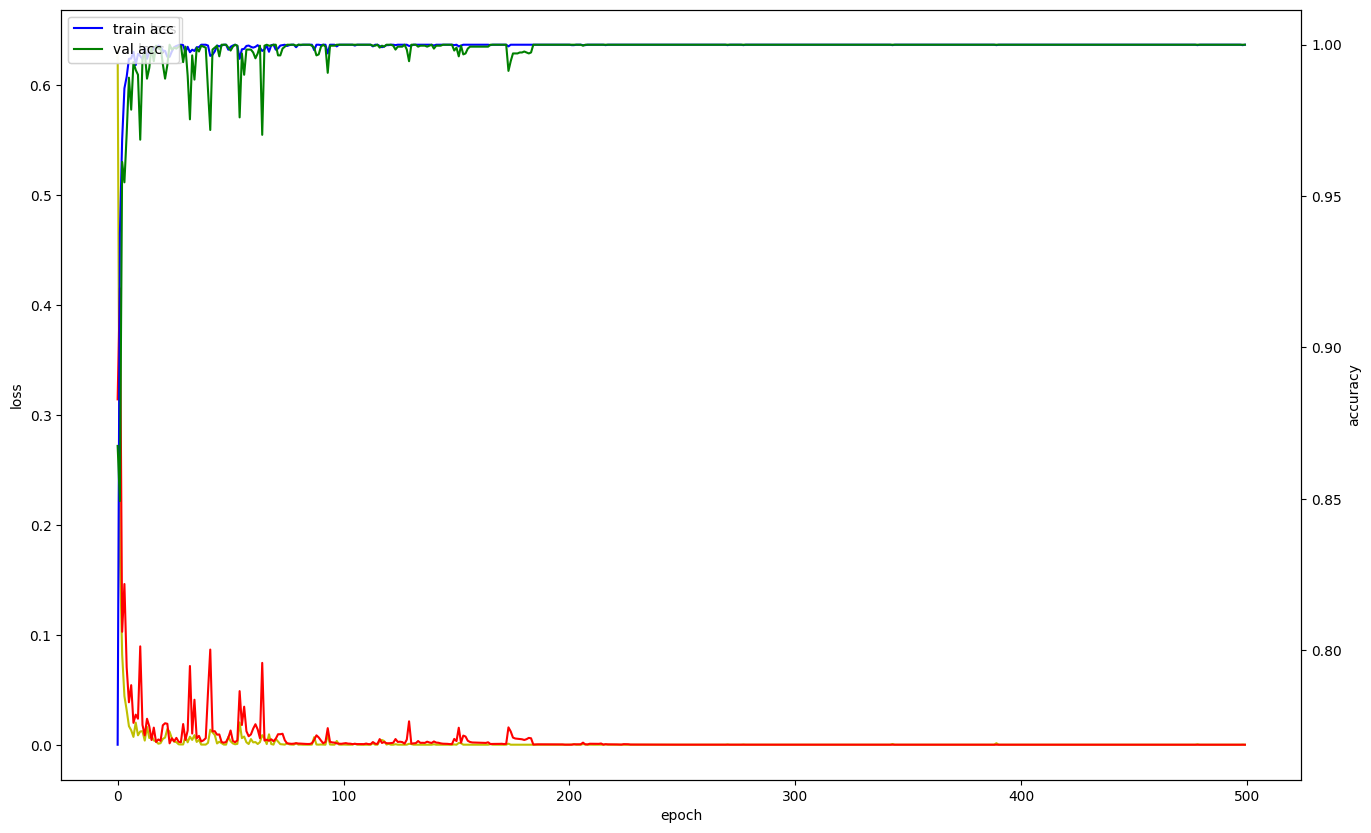

In [15]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [10]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

107/107 [==============================] - 0s 3ms/step


array([[[2618,    1],
        [   4,  799]],

       [[3127,    0],
        [   0,  295]],

       [[2702,    4],
        [   0,  716]],

       [[1814,    0],
        [   1, 1607]]], dtype=int64)